In [1]:
import tensorflow
from tensorflow.python.client import device_lib

In [2]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import glob
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers


%matplotlib inline
folder = '../resources/P300/'
mats = []
mats.append(scipy.io.loadmat(folder+'P300S01.mat'))
mats.append(scipy.io.loadmat(folder+'P300S02.mat'))
mats.append(scipy.io.loadmat(folder+'P300S03.mat'))
mats.append(scipy.io.loadmat(folder+'P300S04.mat'))
mats.append(scipy.io.loadmat(folder+'P300S05.mat'))
mats.append(scipy.io.loadmat(folder+'P300S06.mat'))
mats.append(scipy.io.loadmat(folder+'P300S07.mat'))
mats.append(scipy.io.loadmat(folder+'P300S08.mat'))
folder = folder+'*.mat'
files = glob.glob(folder)

In [3]:
#!pip install sklearn

In [4]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 24.0       # sample rate, Hz
cutoff = 1.5  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
#b, a = butter_lowpass(cutoff, fs, order)

In [5]:
def clean_data(X, Y, flash):
  
    X_samples = np.array([np.array(X[i[0]:i[0]+351]) for i in flash] )
    column    = [i[2] for i in flash]
    label     = [i[3] - 1 for i in flash]

    LIMIT = 4080 #the last trial is incomplete
    X_selected = np.array(X_samples[:LIMIT])
    col_selected = np.array(column[:LIMIT])
    label_selected = np.array(label[:LIMIT])

    y = np.array(to_categorical(label_selected))

    false_idx = [k for k, i in enumerate(y) if i[0] == 1]
    true_idx  = [k for k, i in enumerate(y) if i[0] == 0]

    falseX = X_selected[false_idx]
    falsey = y[false_idx]

    trueX  = X_selected[true_idx]  
    truey  = y[true_idx]
    # proportional data to avoid greedy cost funtion

    proportionalX = falseX[:int(len(trueX))]
    proportionaly = falsey[:int(len(truey))]

    finalX = np.concatenate((trueX, proportionalX))
    finaly = np.concatenate((truey, proportionaly))

    X_timeseries = np.vstack(finalX)
    X_letters = X_timeseries.reshape(34,40,351,8)
    y_letters = finaly.reshape(34,40,2)
    cleaned_X = np.vstack(X_letters)
    cleaned_Y = np.vstack(y_letters)

    return cleaned_X, cleaned_Y

In [6]:
def prepare_data(file):
    allX = []
    allY = []
    allT = []
    allF = []
    raw_data = scipy.io.loadmat(file)
    useful_data = raw_data['data'].copy()
    X = useful_data['X']
    Y = useful_data['y']
    T = useful_data['trial']
    F = useful_data['flash']
    # X_mean = np.mean(X, axis=1)
    X_filtered = butter_lowpass_filter(X, cutoff, fs, order)
    return X_filtered, Y, T, F
    #return X, Y, T, F

In [7]:
appX = []
appy = []
for mat in mats:
    X = mat['data']['X'][0][0]
    y = mat['data']['y'][0][0]
    flash = mat['data']['flash'][0][0]
    cleaned_X, cleaned_Y = clean_data(X,y,flash)      
    appX.append(cleaned_X)
    appy.append(cleaned_Y)
X = [subject for subject in appX]
y = [subject for subject in appy]



C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
#SHUFFLE INCLUDED
X_train, X_temp, y_train, y_temp = train_test_split(np.vstack(X), np.vstack(y), test_size=0.2, random_state=16)
X_val, X_test, y_val, y_test=train_test_split(X_temp, y_temp, test_size=0.5)

print(X_train.shape)
print(y_train.shape)
print()
print(X_val.shape)
print(y_val.shape)
print()
print(X_test.shape)
print(y_test.shape)
print()

(8704, 351, 8)
(8704, 2)

(1088, 351, 8)
(1088, 2)

(1088, 351, 8)
(1088, 2)



In [9]:
def get_model():
    input_layer = keras.Input(shape = (351,8,1), name='main_input')
    x     = layers.Conv2D(16, kernel_size=(8,1), padding='same', activation='relu')(input_layer)
    x     = layers.Conv2D(32, kernel_size=(1,6), padding='same', activation='relu')(x)
    x     = layers.Conv2D(8, 4, padding='same', activation='relu')(x)
    x     = layers.Conv2D(4, 2, padding='same', activation='relu')(x)
    x     = layers.GlobalAveragePooling2D()(x)
    x     = layers.Dense(64, kernel_initializer='ones',
                              kernel_regularizer=tf.keras.regularizers.l1(0.001),
                              activity_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x     = layers.Dropout(0.2)(x)
    x     = layers.Dense(64, kernel_initializer='ones',
                              kernel_regularizer=tf.keras.regularizers.l1(0.001),
                              activity_regularizer=tf.keras.regularizers.l2(0.001))(x)
    output = layers.Dense(2, activation='softmax')(x)

    model = keras.Model(inputs=input_layer, outputs=output)

    model.summary()
    return model

In [10]:
opt = keras.optimizers.Adam(lr=0.001)
model = get_model()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 351, 8, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 351, 8, 16)        144       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 351, 8, 32)        3104      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 351, 8, 8)         4104      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 351, 8, 4)         132       
_________________________________________________________________
global_average_pooling2d (Gl (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [18]:

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size=30,
    epochs=75
)

Epoch 1/75
  1/291 [..............................] - ETA: 0s - loss: 136.9700 - accuracy: 0.5333

InternalError:  cuDNN launch failure : input shape([30,1,352,8]) filter shape([8,1,1,16])
	 [[node functional_1/conv2d/Conv2D (defined at <ipython-input-13-29420d895e1b>:5) ]] [Op:__inference_train_function_1495]

Function call stack:
train_function


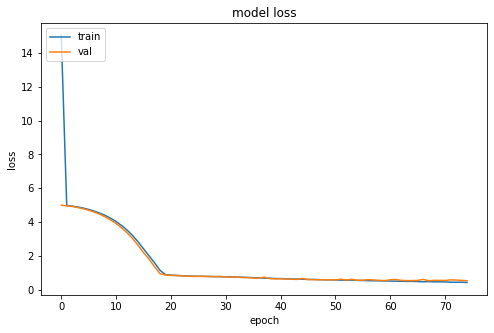

In [15]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

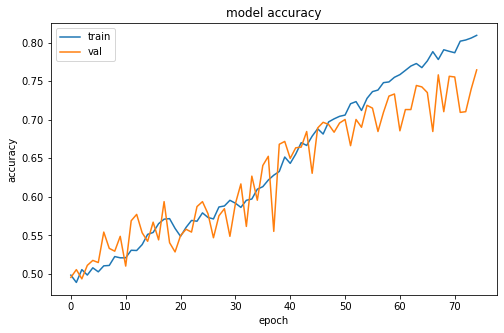

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
##############################################################################
############                     PREDICT                     #################
##############################################################################

In [ ]:
for i in range(len(X_test)):
    input_data=X_test(i)
    gt = Y_test(i)

In [17]:
!nvidia-smi

Mon May  3 18:52:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.92       Driver Version: 461.92       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   52C    P8     8W / 120W |   2177MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 106... WDDM  | 00000000:03:00.0  On |                  N/A |
| 52%   